
# Preprocessing for Segmentation Model

## 1. Preparations
### 1.1 Install required packages

**!!! ATTENTION !!!**    
Select right Kernel/Environment (with PyTorch installed): `pytorch_env_pyth311`

In [32]:
# check current python version and environment
!python --version
!where python 

Python 3.11.11
c:\Users\simon\anaconda3\envs\pytorch_env_pyth311\python.exe
C:\Users\simon\AppData\Local\Microsoft\WindowsApps\python.exe


In [ ]:
# import required packages
import json
import os
import geopandas as gpd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
# !pip install segmentation-models-pytorch

  Using cached segmentation_models_pytorch-0.3.4-py3-none-any.whl.metadata (30 kB)
  Using cached efficientnet_pytorch-0.7.1.tar.gz (21 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached huggingface_hub-0.26.5-py3-none-any.whl.metadata (13 kB)
  Using cached pretrainedmodels-0.7.4.tar.gz (58 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached timm-0.9.7-py3-none-any.whl.metadata (58 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 25.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------------------- 6.2/6.2 MB 29.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16458 sha256=65605e365a5ee3630e9e017c847fbdcf4fe32e6480a4c2dc6acca9441374eb12
 

In [33]:
# import segmentation models module
import segmentation_models_pytorch as smp

### 1.2 Load data

In [10]:
# Data directories on GOOGLE DRIVE  # -------------------->> ADJUSTABLE
# npy patches
patches_dir = r'G:\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\patches'
# JSON class codes
codes_dir = r'G:\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\classes'
# Shapefile class labels
labels_dir = r'G:\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\shapefiles'

In [11]:
# Class labels
# specific Shapefile path
shp_path = os.path.join(labels_dir, "GSK_24_WGS84_adjusted.shp") # -------------------->> ADJUSTABLE

labels = gpd.read_file(shp_path) # read shapefile
labels_filtered = labels[labels["Elementtyp"].notnull()] # remove NULL
print(labels_filtered["Elementtyp"].unique()) # print all label classes

['Einzelstein' 'Wurzelstock' 'Steinverbauung' 'Totholz' 'Steinriegel'
 'Schotterbank' 'Schlamm_Sandinsel' 'Sand_Schlammbank' 'Schotterinsel']


In [12]:
# Class codes
# path
label_codes_path = os.path.join(codes_dir, "label_codes.json")   # -------------------->> ADJUSTABLE

# Open and load the JSON file
with open(label_codes_path, "r") as json_file:
    label_codes = json.load(json_file)

print(label_codes)
len(label_codes)

{'Einzelstein': 1, 'Wurzelstock': 2, 'Steinverbauung': 3, 'Totholz': 4, 'Steinriegel': 5, 'Schotterbank': 6, 'Schlamm_Sandinsel': 7, 'Sand_Schlammbank': 8, 'Schotterinsel': 9}


9

In [15]:
# Test patch

## 2. Choose segmentation model

In [13]:
model = smp.Unet(   # -------------------->> ADJUSTABLE
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (3 for RGB)
    classes=len(label_codes),       # model output channels (number of classes)
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\simon/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 31.2MB/s]


## 3. Configure data preprocessing

Datenvorverarbeitungsfunktion (preprocess_input) für ein bestimmtes Modell (Encoder) konfigurieren:

`from segmentation_models_pytorch.encoders import get_preprocessing_fn`

`preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')`

Encoder = der Teil des neuronalen Netzes, der Features aus den Eingabedaten extrahiert (in diesem Fall das vortrainiertes Modell "resnet" auf ImageNet)
Pretraining = Encoder bereits auf einem großen Datensatz (z. B. ImageNet) trainiert > kann nützliche feature erkennen

Warum Datenvorverarbeitung nötig ist:
- Während des Trainings der vortrainierten Gewichte (z. B. auf ImageNet) wurde eine spezifische Vorverarbeitung auf die Bilder angewendet, z. B. Normalisierung, Größenanpassung oder Farbraumkonvertierung.
- Um die bestmögliche Leistung mit den vortrainierten Gewichten zu erzielen, sollten die Eingabedaten genauso vorverarbeitet werden, wie es während des Pretrainings gemacht wurde.

Was `get_preprocessing_fn` macht:
Diese Funktion liefert eine Vorverarbeitungsfunktion (preprocess_input), die genau die gleichen Transformationen durchführt, die während des Pretrainings auf den ImageNet-Datensatz angewendet wurden.





In [ ]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet') # load specific (suitable to chosen model) preprocessing function

In [16]:
# create output directory for preprocessed patches
preprocessed_patches_dir = r'G:\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\preprocessed_patches'
if not os.path.exists(preprocessed_patches_dir):
    os.makedirs(preprocessed_patches_dir)

In [ ]:
patches_list = [f for f in os.listdir(patches_dir) if not f.endswith('_mask.npy')]  # list of all patches (not the masks)
patches_list.sort() # sort list alphabetically
# patches_list

['A01_patch_0.npy',
 'A01_patch_1.npy',
 'A01_patch_10.npy',
 'A01_patch_100.npy',
 'A01_patch_101.npy',
 'A01_patch_102.npy',
 'A01_patch_103.npy',
 'A01_patch_104.npy',
 'A01_patch_105.npy',
 'A01_patch_106.npy',
 'A01_patch_107.npy',
 'A01_patch_108.npy',
 'A01_patch_109.npy',
 'A01_patch_11.npy',
 'A01_patch_110.npy',
 'A01_patch_111.npy',
 'A01_patch_112.npy',
 'A01_patch_113.npy',
 'A01_patch_114.npy',
 'A01_patch_115.npy',
 'A01_patch_116.npy',
 'A01_patch_117.npy',
 'A01_patch_118.npy',
 'A01_patch_119.npy',
 'A01_patch_12.npy',
 'A01_patch_120.npy',
 'A01_patch_121.npy',
 'A01_patch_122.npy',
 'A01_patch_123.npy',
 'A01_patch_124.npy',
 'A01_patch_125.npy',
 'A01_patch_126.npy',
 'A01_patch_127.npy',
 'A01_patch_128.npy',
 'A01_patch_129.npy',
 'A01_patch_13.npy',
 'A01_patch_130.npy',
 'A01_patch_131.npy',
 'A01_patch_132.npy',
 'A01_patch_133.npy',
 'A01_patch_134.npy',
 'A01_patch_135.npy',
 'A01_patch_136.npy',
 'A01_patch_137.npy',
 'A01_patch_138.npy',
 'A01_patch_139.np

In [18]:
# PREPROCESSING LOOP

for idx, patch_name in enumerate(patches_list): # iterate over all patches
    patch_path = os.path.join(patches_dir, patch_name)  # path to specific patch
    patch = np.load(patch_path, allow_pickle= True)  # load npy file as dictionary object (allow pickle = True)
    image_data = patch.item().get('image')   # extract image key from dictionary

    # print(f"Processing patch {idx + 1}/{len(patches_list)}: {patch_name}")
    # print(image_data.shape)

    # check if image has the right shape: [height, width, color channels]
    if image_data.shape[0] in [1, 3]:  # shape is: [C, H, W]
        image_data = image_data.transpose(1, 2, 0)  # [H, W, C]
    # print(image_data.shape)

    # use the preprocessing function
    preprocessed_image_data = preprocess_input(image_data)

    # transpose back to [C, H, W]
    preprocessed_image_data = preprocessed_image_data.transpose(2, 0, 1)

    # save preprocessed patch
    output_path = os.path.join(preprocessed_patches_dir, patch_name)
    np.save(output_path, preprocessed_image_data)

    # display progress
    if idx % 100 == 0:
        print(f"Processed {idx}/{len(patches_list)} patches")

Processed 0/11173 patches
Processed 100/11173 patches
Processed 200/11173 patches
Processed 300/11173 patches
Processed 400/11173 patches


KeyboardInterrupt: 

Check if preprocessing works!

In [29]:
SECTION = "A01"
TEST_PATCH_ID = 167 # -------------------->> ADJUSTABLE

In [30]:
# preprocessed patch path
preprocessed_patch_path = preprocessed_patches_dir + f"/{SECTION}_patch_{TEST_PATCH_ID}.npy"

# load NumpyArray (NO DICTIONARY ANYMORE)
preprocessed_patch = np.load(preprocessed_patch_path)

FileNotFoundError: [Errno 2] No such file or directory: 'G:\\Meine Ablage\\Dokumente.GD\\FS06 SS24\\BACHELORARBEIT\\MoSE\\data\\preprocessed_patches/A01_patch_167.npy'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.6399999999999997].


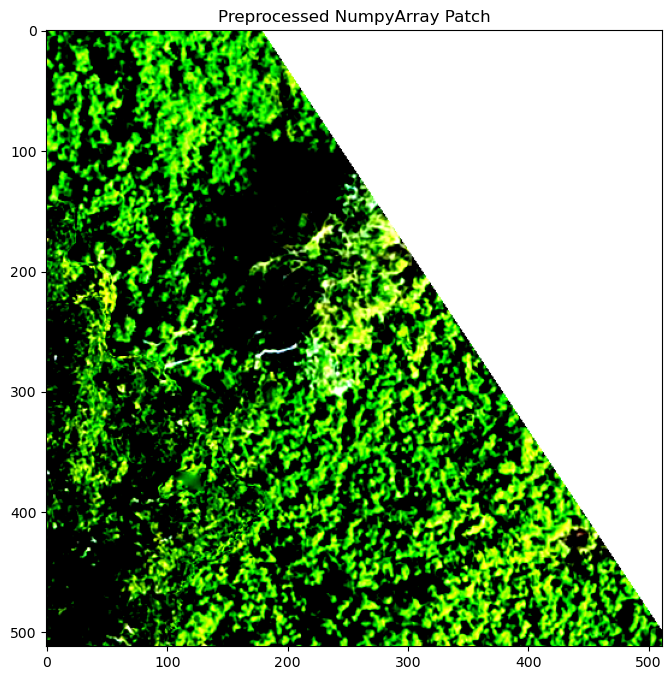

In [28]:
# plot the preprocessed image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(preprocessed_patch.transpose(1, 2, 0))  # transpose for RGB depiction
ax.set_title("Preprocessed NumpyArray Patch")
plt.show()